In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [131]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json
from collections import Counter 

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [120]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [249]:
dataset = 'dsprites'
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'

In [250]:
dataset_name = "dsprites"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/dsprites/preprocessed/'

In [251]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = train_data_path.replace('train.pkl','extra.pkl')

In [252]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [253]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)
extra_loader = load_data([extra_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, 
                        n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [254]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/dsprites/joint_model_small3/joint/best_model_42.pth


## Plot the Dataset

In [255]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))
extra_pkl = pickle.load(open(extra_data_path,"rb"))

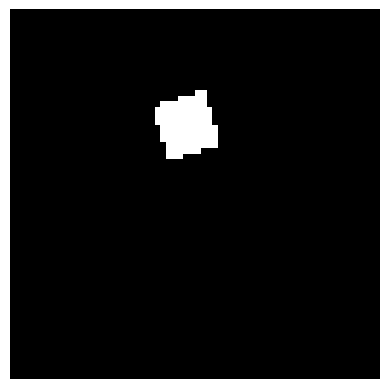

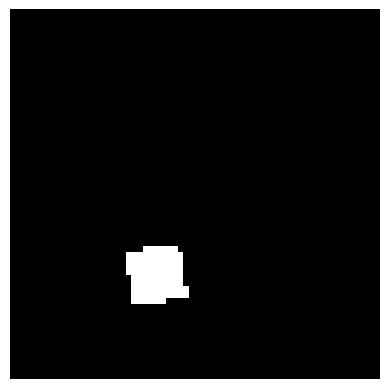

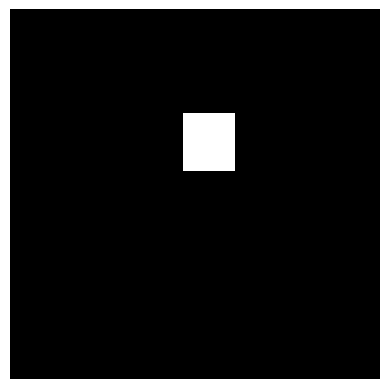

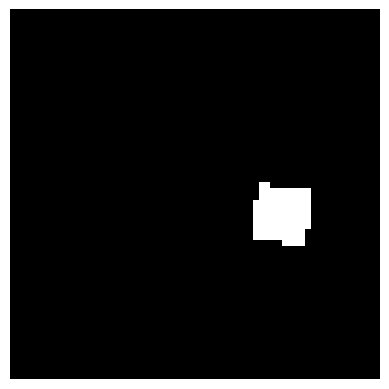

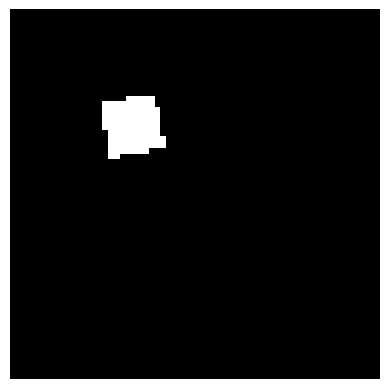

In [256]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+extra_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 

In [257]:
extra_images, extra_y, extra_c = unroll_data(extra_loader)

In [229]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

(tensor(1.), tensor(1.))

In [230]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Run Model over all Concept Combinations

In [258]:
_, extra_predictions = run_joint_model(joint_model,extra_images)

In [259]:
extra_predictions = extra_predictions.T

In [260]:
extra_predictions = torch.nn.Sigmoid()(extra_predictions)

In [261]:
attributes_as_matrix = np.array([i['attribute_label'] for i in extra_pkl])

In [262]:
concept_names = [
    "is_white",
    "is_square",
    "is_ellipse",
    "is_heart",
    "is_scale_0.5",
    "is_scale_0.6",
    "is_scale_0.7",
    "is_scale_0.8",
    "is_scale_0.9",
    "is_scale_1",
    "is_orientation_0",
    "is_orientation_90",
    "is_orientation_180",
    "is_orientation_270",
    "is_x_0",
    "is_x_16",
    "is_y_0",
    "is_y_16",
] 

In [263]:
results = {}
num_concepts = extra_predictions.shape[1]
for i in range(num_concepts):
    data_points_with_concept = np.where(attributes_as_matrix[:, i] == 1)[0]
    data_points_without_concept = np.where(attributes_as_matrix[:, i] == 0)[0]

    min_with_concept = torch.min(extra_predictions[data_points_with_concept,i]).item()
    max_with_concept = torch.max(extra_predictions[data_points_with_concept,i]).item()
    argmin_with_concept = data_points_with_concept[torch.argmin(extra_predictions[data_points_with_concept,i]).item()].item()
    argmax_with_concept = data_points_with_concept[torch.argmax(extra_predictions[data_points_with_concept,i]).item()].item()
    freq_with_concept_adversarial = (len([p for p in data_points_with_concept if extra_predictions[p, i] < 0.75]),len(data_points_with_concept))

    if len(data_points_without_concept) == 0:
        min_without_concept = -1
        max_without_concept = -1

        argmin_without_concept = -1
        argmax_without_concept = -1
    else:
        min_without_concept = torch.min(extra_predictions[data_points_without_concept,i]).item()
        max_without_concept = torch.max(extra_predictions[data_points_without_concept,i]).item()

        argmin_without_concept = data_points_without_concept[torch.argmin(extra_predictions[data_points_without_concept,i]).item()].item()
        argmax_without_concept = data_points_without_concept[torch.argmax(extra_predictions[data_points_without_concept,i]).item()].item()

    results[concept_names[i]] = {
        'min_with_concept': min_with_concept, 
        'max_with_concept': max_with_concept, 
        'min_without_concept': min_without_concept, 
        'max_without_concept': max_without_concept,
        'freq_with_concept_adversarial': freq_with_concept_adversarial,
        'argmin_with_concept': argmin_with_concept, 
        'argmax_with_concept': argmax_with_concept, 
        'argmin_without_concept': argmin_without_concept, 
        'argmax_without_concept': argmax_without_concept,
    }

In [264]:
total_adversarial = np.sum([results[i]['freq_with_concept_adversarial'][0] for i in results])/np.sum([results[i]['freq_with_concept_adversarial'][1] for i in results])
total_adversarial

0.37037037037037035

In [265]:
results 

{'is_white': {'min_with_concept': 1.0,
  'max_with_concept': 1.0,
  'min_without_concept': -1,
  'max_without_concept': -1,
  'freq_with_concept_adversarial': (0, 288),
  'argmin_with_concept': 0,
  'argmax_with_concept': 0,
  'argmin_without_concept': -1,
  'argmax_without_concept': -1},
 'is_square': {'min_with_concept': 8.369874849496974e-20,
  'max_with_concept': 1.0,
  'min_without_concept': 1.1486685682457296e-22,
  'max_without_concept': 1.0,
  'freq_with_concept_adversarial': (31, 96),
  'argmin_with_concept': 1,
  'argmax_with_concept': 11,
  'argmin_without_concept': 109,
  'argmax_without_concept': 103},
 'is_ellipse': {'min_with_concept': 1.661449140339466e-23,
  'max_with_concept': 1.0,
  'min_without_concept': 3.525775950561862e-24,
  'max_without_concept': 1.0,
  'freq_with_concept_adversarial': (91, 96),
  'argmin_with_concept': 127,
  'argmax_with_concept': 179,
  'argmin_without_concept': 219,
  'argmax_without_concept': 71},
 'is_heart': {'min_with_concept': 8.483402

In [266]:
json.dump(results,open('results/dsprites/adversarial_with_rotation.json','w'))

## Dataset Exploration

In [267]:
def list_to_string(l):
    return ''.join([str(i) for i in l])

In [268]:
list_to_index = {}
for i in range(len(extra_pkl)):
    list_to_index[list_to_string(extra_pkl[i]['attribute_label'])] = i

In [269]:
present_concept_combo = list(set([list_to_string(i['attribute_label']) for i in train_pkl]))

In [270]:
concept_of_interest = 'is_heart'
concept_idx = concept_names.index(concept_of_interest)
argmin_with_concept = results[concept_of_interest]['argmin_with_concept']
argmax_with_concept = results[concept_of_interest]['argmax_with_concept']

In [271]:
extra_pkl[argmin_with_concept]['attribute_label'][concept_idx], extra_pkl[argmax_with_concept]['attribute_label'][concept_idx] 

(1, 1)

8.483402422878735e-29


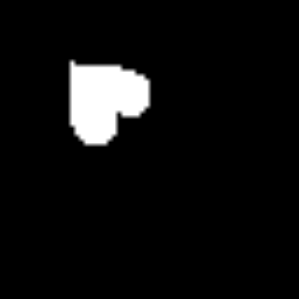

In [272]:
print(extra_predictions[argmin_with_concept][concept_idx].item())
numpy_to_pil(extra_images[argmin_with_concept].detach().numpy())

1.0


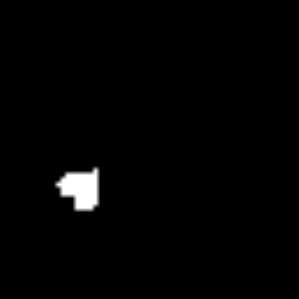

In [273]:
print(extra_predictions[argmax_with_concept][concept_idx].item())
numpy_to_pil(extra_images[argmax_with_concept].detach().numpy())

In [274]:
combo_with_concept = [i for i in present_concept_combo if i[concept_idx] == '1']
for i in combo_with_concept:
    print([concept_names[j] for j in range(len(concept_names)) if i[j] == '1'])
combo_with_concept

['is_white', 'is_heart', 'is_scale_0.6', 'is_orientation_0', 'is_x_0', 'is_y_0']
['is_white', 'is_heart', 'is_scale_0.6', 'is_orientation_180', 'is_x_0', 'is_y_16']
['is_white', 'is_heart', 'is_scale_0.8', 'is_orientation_180', 'is_x_16', 'is_y_0']
['is_white', 'is_heart', 'is_scale_1', 'is_orientation_180', 'is_x_0', 'is_y_16']


['100101000010001010',
 '100101000000101001',
 '100100010000100110',
 '100100000100101001']

In [275]:
extra_predictions[[list_to_index[i] for i in combo_with_concept],concept_idx]

tensor([0.9928, 1.0000, 0.9967, 1.0000], grad_fn=<IndexBackward0>)

In [276]:
all_with_1 = []
for i in list_to_index:
    if i[concept_idx] == '1':
        distances = [hamming_distance(i,j) for j in combo_with_concept]
        idx = np.argmin(distances)
        min_dist = distances[idx] 
        flipped_concepts = hamming_distance(i,combo_with_concept[idx],diff_names=concept_names,ret_diff=True)
        idx = list_to_index[i] 
        pred = extra_predictions[idx,concept_idx]
        all_with_1.append({'dist': min_dist, 'name': i, 'prediction': pred.item(), 'differences': flipped_concepts[1]})
predictions = [i['prediction'] for i in all_with_1]

In [277]:
sorted(all_with_1,key=lambda k: -k['prediction'])

[{'dist': 4,
  'name': '100110000001001001',
  'prediction': 1.0,
  'differences': ['is_scale_0.5',
   'is_scale_0.6',
   'is_orientation_90',
   'is_orientation_180']},
 {'dist': 4,
  'name': '100110000001000110',
  'prediction': 1.0,
  'differences': ['is_scale_0.5',
   'is_scale_0.8',
   'is_orientation_90',
   'is_orientation_180']},
 {'dist': 2,
  'name': '100110000000101001',
  'prediction': 1.0,
  'differences': ['is_scale_0.5', 'is_scale_0.6']},
 {'dist': 2,
  'name': '100110000000100110',
  'prediction': 1.0,
  'differences': ['is_scale_0.5', 'is_scale_0.8']},
 {'dist': 4,
  'name': '100110000000010110',
  'prediction': 1.0,
  'differences': ['is_scale_0.5',
   'is_scale_0.8',
   'is_orientation_180',
   'is_orientation_270']},
 {'dist': 6,
  'name': '100110000000010101',
  'prediction': 1.0,
  'differences': ['is_scale_0.5',
   'is_scale_0.6',
   'is_orientation_180',
   'is_orientation_270',
   'is_x_0',
   'is_x_16']},
 {'dist': 2,
  'name': '100101000010001001',
  'predict

In [278]:
list_flatten_1 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] >= 0.75]))
list_flatten_0 = list(itertools.chain(*[i['differences'] for i in all_with_1 if i['prediction'] < 0.75]))

In [279]:
counter_1 = Counter(list_flatten_1)
counter_0 = Counter(list_flatten_0) 

for i in counter_1:
    counter_1[i] /= len(list_flatten_1)
    counter_1[i] = round(counter_1[i],2)

    if i not in counter_0:
        counter_0[i] = 0.0

for i in counter_0:
    counter_0[i] /= len(list_flatten_0)
    counter_0[i] = round(counter_0[i],2)

    if i not in counter_1:
        counter_1[i] = 0.0

counter_0 = dict(counter_0)
counter_1 = dict(counter_1)

In [280]:
counter_1

{'is_scale_0.5': 0.1,
 'is_scale_0.6': 0.18,
 'is_x_0': 0.07,
 'is_x_16': 0.07,
 'is_y_0': 0.04,
 'is_y_16': 0.04,
 'is_orientation_0': 0.05,
 'is_orientation_90': 0.1,
 'is_orientation_180': 0.14,
 'is_scale_0.8': 0.08,
 'is_orientation_270': 0.07,
 'is_scale_0.7': 0.06,
 'is_scale_0.9': 0.03,
 'is_scale_1': 0.0}

In [281]:
counter_0

{'is_scale_0.5': 0.02,
 'is_scale_0.6': 0.15,
 'is_y_0': 0.05,
 'is_y_16': 0.05,
 'is_orientation_90': 0.06,
 'is_orientation_180': 0.12,
 'is_x_0': 0.1,
 'is_x_16': 0.1,
 'is_orientation_0': 0.08,
 'is_orientation_270': 0.08,
 'is_scale_0.7': 0.04,
 'is_scale_0.8': 0.05,
 'is_scale_0.9': 0.06,
 'is_scale_1': 0.04}

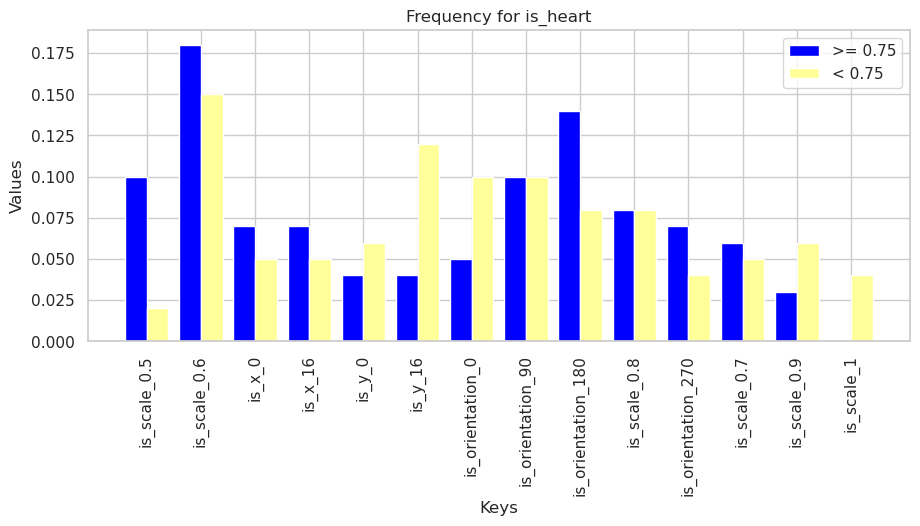

In [282]:
keys = list(counter_1.keys())
values_1 = list(counter_1.values())
values_0 = list(counter_0.values())

width = 0.4  # Width of the bars
x = np.arange(len(keys))  # Numeric locations for the bars

plt.bar(x - width/2, values_1, width, color='blue', label='>= 0.75')
plt.bar(x + width/2, values_0, width, color='#FFFF99', label='< 0.75')  # Light yellow

plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('Frequency for {}'.format(concept_of_interest))
plt.xticks(x, keys, rotation='vertical')  # Rotate x-axis labels vertically
plt.legend()
plt.tight_layout()  # Adjust layout for better appearance
plt.gcf().set_size_inches(10, 6)  # Adjust the width of the graph
plt.show()

/rds/user/njr61/hpc-work/anaconda3/envs/cem/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  


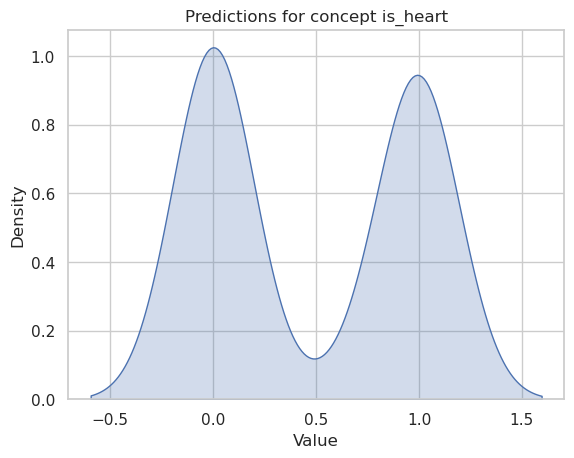

In [283]:
sns.set(style="whitegrid")  # Set the style of the plot
sns.kdeplot(predictions, shade=True)  # Create the kernel density plot
plt.xlabel("Value")  # Label for x-axis
plt.ylabel("Density")  # Label for y-axis
plt.title("Predictions for concept {}".format(concept_of_interest))  # Title of the plot
plt.show()  # Show the plot

In [284]:
sorted(all_with_1,key=lambda k: k['prediction'])

[{'dist': 2,
  'name': '100100000100101010',
  'prediction': 8.483402422878735e-29,
  'differences': ['is_y_0', 'is_y_16']},
 {'dist': 4,
  'name': '100100000101001010',
  'prediction': 6.852553218083947e-23,
  'differences': ['is_scale_0.6',
   'is_scale_1',
   'is_orientation_0',
   'is_orientation_90']},
 {'dist': 2,
  'name': '100100000100100101',
  'prediction': 1.342607535304742e-21,
  'differences': ['is_x_0', 'is_x_16']},
 {'dist': 4,
  'name': '100100000101000110',
  'prediction': 9.974530274606835e-20,
  'differences': ['is_scale_0.8',
   'is_scale_1',
   'is_orientation_90',
   'is_orientation_180']},
 {'dist': 4,
  'name': '100100001000011010',
  'prediction': 1.506735459236574e-17,
  'differences': ['is_scale_0.6',
   'is_scale_0.9',
   'is_orientation_0',
   'is_orientation_270']},
 {'dist': 4,
  'name': '100100001000101010',
  'prediction': 4.261503821336415e-17,
  'differences': ['is_scale_0.6',
   'is_scale_0.9',
   'is_orientation_0',
   'is_orientation_180']},
 {'dis

In [285]:
example_combo = sorted(all_with_1,key=lambda k: k['prediction'])[0]['name']
closest_combo = combo_with_concept[np.argmin([hamming_distance(example_combo,j) for j in combo_with_concept])]

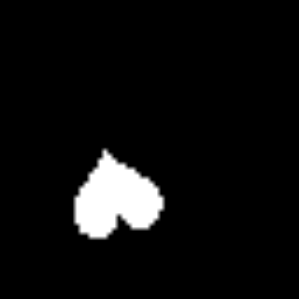

In [286]:
numpy_to_pil(extra_images[list_to_index[closest_combo]].detach().numpy())

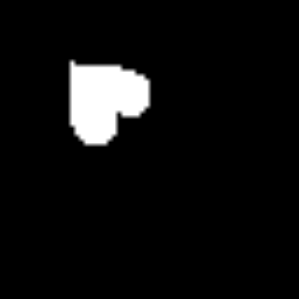

In [287]:
numpy_to_pil(extra_images[list_to_index[example_combo]].detach().numpy())